In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

In [2]:
%matplotlib inline

In [3]:
def make_uniform(qs, name=None, **options):
    """Make a Pmf that represents a uniform distribution."""
    pmf = Pmf(1.0, qs, **options)
    pmf.normalize()
    if name:
        pmf.index.name = name
    return pmf

def make_joint(pmf1, pmf2):
    """Compute the outer product of two Pmfs."""
    X, Y = np.meshgrid(pmf1, pmf2)
    return pd.DataFrame(X * Y, columns=pmf1.qs, index=pmf2.qs)

def plot_contour(joint):
    """Plot a joint distribution with a contour."""
    plt.contour(joint.columns, joint.index, joint,
                linewidths=2)
    
def marginal(joint, axis):
    """Compute a marginal distribution."""
    return Pmf(joint.sum(axis=axis))

In [4]:
from empiricaldist import Pmf

from scipy.stats import binom

In [5]:
# Toy problem involving female students showing up to engineering class

def prob(o):
    return o / (o+1)

In [6]:
index = ['prior', '1 student', '2 students', '3 students']

table = pd.DataFrame(index=index)
table['odds'] = [10, 10/3, 10/9, 10/27]
table['prob'] = prob(table['odds'])
table['prob diff'] = table['prob'].diff() * 100
table.fillna('--')

,odds,prob,prob diff
prior,10.000000,0.909091,--
1 student,3.333333,0.769231,-13.986014
2 students,1.111111,0.526316,-24.291498
3 students,0.370370,0.270270,-25.604552


In [7]:
table['log odds'] = np.log(table['odds'])
table['log odds diff'] = table['log odds'].diff()
table.fillna('--')

,odds,prob,prob diff,log odds,log odds diff
prior,10.000000,0.909091,--,2.302585,--
1 student,3.333333,0.769231,-13.986014,1.203973,-1.098612
2 students,1.111111,0.526316,-24.291498,0.105361,-1.098612
3 students,0.370370,0.270270,-25.604552,-0.993252,-1.098612


In [8]:
# The log odds between updates are equally spaced, as becomes obvious when we take the log of both sides of Bayes Rule

# Example with Challenger data

data = pd.read_csv('https://raw.githubusercontent.com/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/master/Chapter2_MorePyMC/data/challenger_data.csv?raw=true', parse_dates=[0])

In [10]:
data

,Date,Temperature,Damage Incident
0,04/12/1981,66,0
1,11/12/1981,70,1
2,3/22/82,69,0
3,6/27/82,80,NaN
4,01/11/1982,68,0
5,04/04/1983,67,0
6,6/18/83,72,0
7,8/30/83,73,0
8,11/28/83,70,0
9,02/03/1984,57,1


In [11]:
# Avoid column names with spaces

data.rename(columns={'Damage Incident': 'Damage'}, inplace=True)

# Drop row 3, in which Damage is Nan, and row 24, which is the Challenger incident

data.drop(labels=[3, 24], inplace=True)

# Convert the damage data to integers

data['Damage'] = data['Damage'].astype(int)

In [12]:
data

,Date,Temperature,Damage
0,04/12/1981,66,0
1,11/12/1981,70,1
2,3/22/82,69,0
4,01/11/1982,68,0
5,04/04/1983,67,0
6,6/18/83,72,0
7,8/30/83,73,0
8,11/28/83,70,0
9,02/03/1984,57,1
10,04/06/1984,63,1


Text(0.5, 1.0, 'Damage to O-Rings by Temperature')

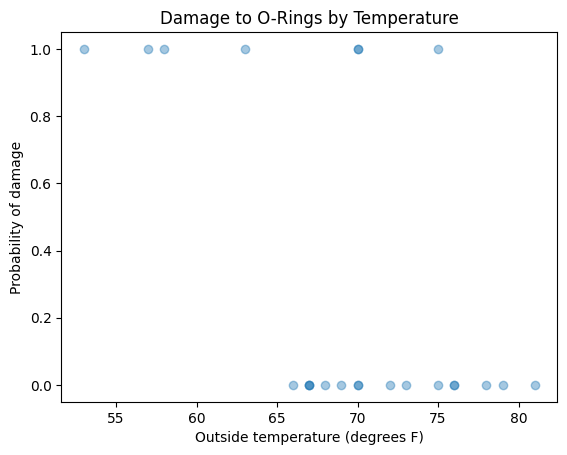

In [13]:
plt.plot(data['Temperature'], data['Damage'], 'o', color='C0', alpha=0.4)
plt.xlabel('Outside temperature (degrees F)')
plt.ylabel('Probability of damage')
plt.title('Damage to O-Rings by Temperature')

In [14]:
# We might assume the relationship between temperature and damage is logistic

# Before we explore this, we define x to be temperature shifted by an offset so its mean is 0

offset = data['Temperature'].mean().round()
data['x'] = data['Temperature'] - offset
offset

np.float64(70.0)

In [15]:
data['y'] = data['Damage']

In [43]:
# First we might fit a frequentist logistic regression

import statsmodels.formula.api as smf

formula = 'y ~ x'
results = smf.logit(formula, data=data).fit(disp=False)
results.params

Intercept    1.113137
x           -0.232163
dtype: float64

In [44]:
inter = results.params['Intercept']
slope = results.params['x']
xs = np.arange(53, 83) - offset

log_odds = inter + slope * xs

odds = np.exp(log_odds)
ps = odds / (odds + 1)

In [19]:
ps.mean()

np.float64(0.4155141126966854)

In [45]:
from scipy.special import expit

ps = expit(inter + slope * xs)
ps.mean()

np.float64(0.7218101297716909)

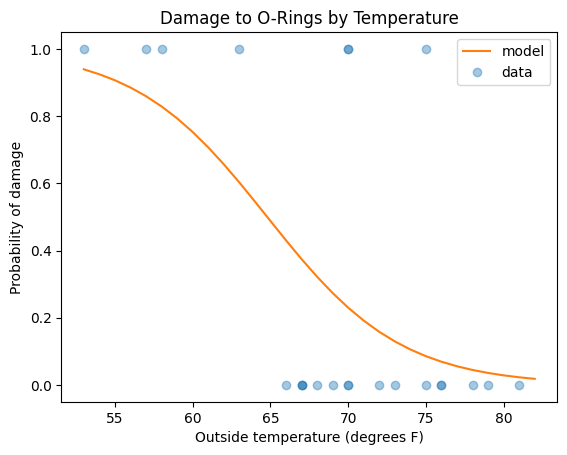

In [22]:
plt.plot(xs+offset, ps, label='model', color='C1')
plt.plot(data['Temperature'], data['Damage'], 'o', label='data', color='C0', alpha=0.4)
plt.xlabel('Outside temperature (degrees F)')
plt.ylabel('Probability of damage')
plt.title('Damage to O-Rings by Temperature')
plt.legend()

In [46]:
# But that's a conventional logit regression; now for the Bayesian version

qs = np.linspace(-5, 1, num=101)
prior_inter = make_uniform(qs, 'Intercept')

qs = np.linspace(-0.8, 0.1, num=101)
prior_slope = make_uniform(qs, 'Slope')

joint = make_joint(prior_inter, prior_slope)

joint_pmf = Pmf(joint.stack())

In [47]:
# To make the likelihood easier, we group the data by temperature, and count launches and damages at each group

grouped = data.groupby('x')['y'].agg(['count', 'sum'])

ns = grouped['count']
ks = grouped['sum']

xs = grouped.index
ps = expit(inter + slope * xs) # This assumes that the parameters we estimated are correct

likes = binom.pmf(ks, ns, ps)

likelihood = joint_pmf.copy()
for slope, inter in joint_pmf.index:
    ps = expit(inter + slope * xs)
    likes = binom.pmf(ks, ns, ps)
    likelihood[slope, inter] = likes.prod()

In [48]:
posterior_pmf = joint_pmf * likelihood
posterior_pmf.normalize()

np.float64(1.2750098487873762e-05)

In [26]:
# Because we used a uniform prior, the parameter pair with the highest likelihood is the pair with max posterior probability

pd.Series(posterior_pmf.max_prob(), index=['slope', 'inter'])

slope   -0.233
inter   -1.220
dtype: float64

In [27]:
results.params # The results of our Bayesian analysis are consistent with the ML estimate from statsmodels

Intercept   -1.208490
x           -0.232163
dtype: float64

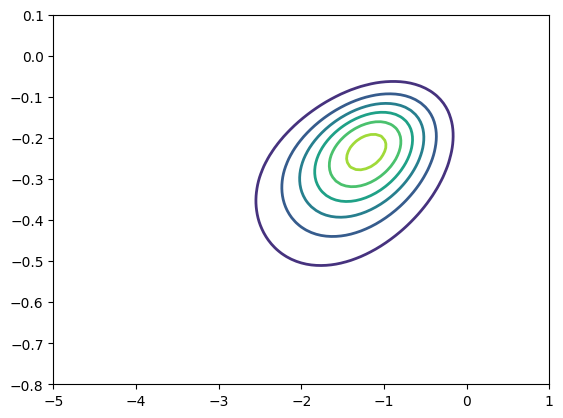

In [28]:
joint_posterior = posterior_pmf.unstack()
plot_contour(joint_posterior)

In [29]:
# Exercise 16-1 - to see why the offset matters, run the analysis with offset=60. 
# Should be same slope but different intercept, and the contour plot of the joint distribution should be elongated
# Centering the data maximizes the precision of the estimates

offset2 = 60
data['x'] = data['Temperature'] - offset2
offset2

60

In [30]:
formula = 'y ~ x'
results = smf.logit(formula, data=data).fit(disp=False)

inter = results.params['Intercept']
slope = results.params['x']

grouped = data.groupby('x')['y'].agg(['count', 'sum'])

ns = grouped['count']
ks = grouped['sum']

xs = grouped.index
ps = expit(inter + slope * xs) # This assumes that the parameters we estimated are correct

likes = binom.pmf(ks, ns, ps)

likelihood = joint_pmf.copy()
for slope, inter in joint_pmf.index:
    ps = expit(inter + slope * xs)
    likes = binom.pmf(ks, ns, ps)
    likelihood[slope, inter] = likes.prod()
    
posterior_pmf = joint_pmf * likelihood
posterior_pmf.normalize()

pd.Series(posterior_pmf.max_prob(), index=['slope', 'inter']) # THIS IS RIGHT

slope   -0.224
inter    1.000
dtype: float64

In [31]:
marginal_inter = marginal(joint_posterior, 0)
marginal_slope = marginal(joint_posterior, 1)

<Axes: title={'center': 'Posterior marginal distribution of intercept'}, xlabel='Intercept', ylabel='PDF'>

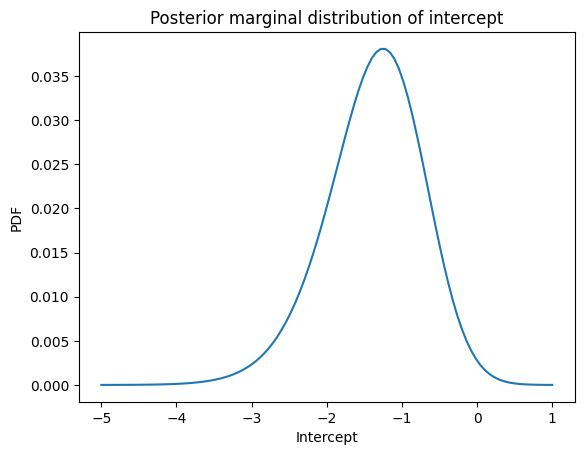

In [32]:
marginal_inter.plot(title='Posterior marginal distribution of intercept', xlabel='Intercept', ylabel='PDF')

<Axes: title={'center': 'Posterior marginal distribution of slope'}, xlabel='Slope', ylabel='PDF'>

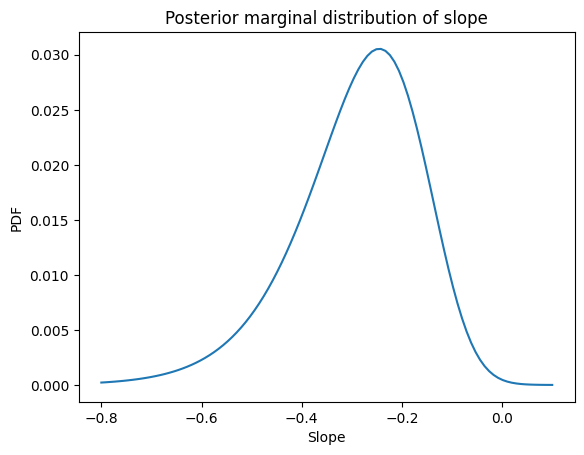

In [33]:
marginal_slope.plot(title='Posterior marginal distribution of slope', xlabel='Slope', ylabel='PDF')

In [35]:
pd.Series([marginal_inter.mean(), marginal_slope.mean()], index=['Intercept', 'Slope'])

Intercept   -1.376107
Slope       -0.289795
dtype: float64

In [36]:
# function to convert the log odds in the intercept to probabilities

def transform(pmf, func):
    ps = pmf.ps
    qs = func(pmf.qs)
    return Pmf(ps, qs, copy=True)

In [37]:
marginal_probs = transform(marginal_inter, expit)

<Axes: title={'center': 'Posterior marginal distribution of probabilities'}, xlabel='Probability of damage at 70 F', ylabel='PDF'>

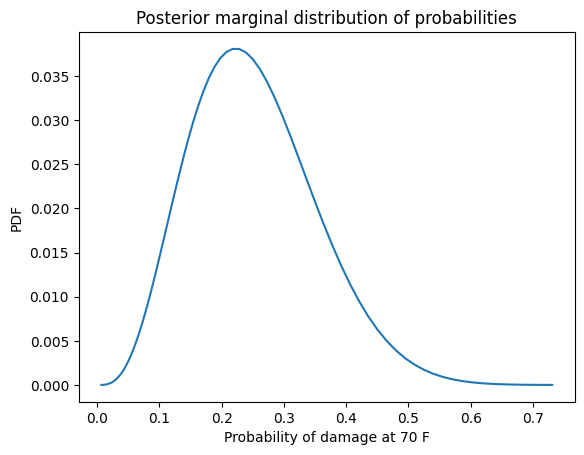

In [38]:
marginal_probs.plot(title='Posterior marginal distribution of probabilities', xlabel='Probability of damage at 70 F', ylabel='PDF')

In [39]:
print(marginal_probs.mean()) # Avg probability of damage at 70 degrees

# This is another reason to use the 70-degree offset: so the intercept corresponds to the prob of damage at a relevant temp, not 0 degrees


0.2201937884647988


In [40]:
# We can interpret the quantities in marginal_slope as log likelihood ratios, and transform them accordingly

marginal_lr = marginal_slope.transform(np.exp)

<Axes: title={'center': 'Posterior marginal distribution of likelihood ratios'}, xlabel='LR of 1', ylabel='PDF'>

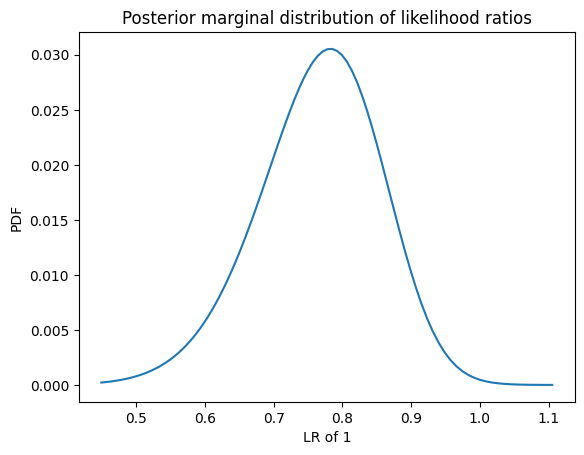

In [41]:
marginal_lr.plot(title='Posterior marginal distribution of likelihood ratios', xlabel='LR of 1', ylabel='PDF')

In [42]:
print(marginal_lr.mean()) # Mean LR < 1, so each additional degree F provides evidence against Pr(damage)

0.7542914170110268


In [49]:
# The question we want to answer requires a predictive distribution:
# What is the prob of damage at 31 degrees?

# First, sample parameter pairs from the posterior

sample = posterior_pmf.choice(101)

In [50]:
# To generate predictions, we'll use a range from 31 degrees to 82 (highest observed temp)

temps = np.arange(31, 83)
xs = temps - offset

# Then we construct an array of predicted probabilities

pred = np.empty((len(sample), len(xs)))

for i, (slope, inter) in enumerate(sample):
    pred[i] = expit(inter + slope * xs)

Text(0.5, 1.0, 'Damage to O-Rings by Temperature')

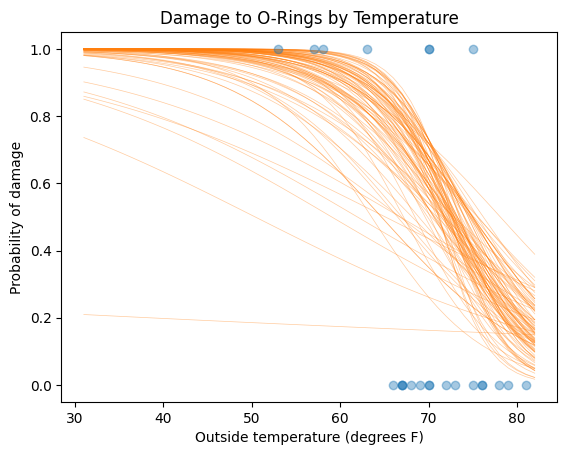

In [51]:
# We can start by plotting the predictions

for ps in pred:
    plt.plot(temps, ps, color='C1', lw=0.5, alpha=0.4)
    
plt.plot(data['Temperature'], data['Damage'], 'o', color='C0', alpha=0.4)
plt.xlabel('Outside temperature (degrees F)')
plt.ylabel('Probability of damage')
plt.title('Damage to O-Rings by Temperature')

In [52]:
# We can compute medians to quantify central tendency and credible intervals to quantify uncertainty

low, median, high = np.percentile(pred, [5, 50, 95], axis=0)

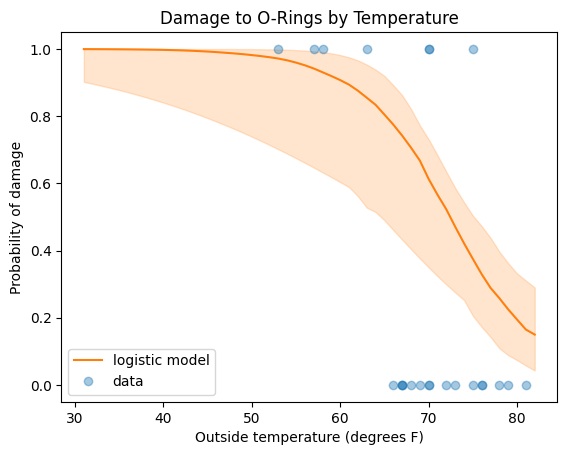

In [53]:
plt.fill_between(temps, low, high, color='C1', alpha=0.2)
plt.plot(temps, median, color='C1', label='logistic model')
plt.plot(data['Temperature'], data['Damage'], 'o', label='data', color='C0', alpha=0.4)
plt.xlabel('Outside temperature (degrees F)')
plt.ylabel('Probability of damage')
plt.title('Damage to O-Rings by Temperature')
plt.legend()

In [54]:
# We can use the model to see the predictions at 80 degrees, 60 degrees, and 31 degrees

low = pd.Series(low, temps)
median = pd.Series(median, temps)
high = pd.Series(high, temps)

# 80 degrees

print(median[80], (low[80], high[80]))

0.19466158359157792 (np.float64(0.07378164660246526), np.float64(0.3318122278318338))


In [55]:
# 60 degrees

print(median[60], (low[60], high[60]))

0.9072070468828429 (np.float64(0.603483249864726), np.float64(0.9818363089715674))


In [56]:
# 31 degrees

print(median[31], (low[31], high[31]))

0.9994477735603098 (np.float64(0.9018543117002693), np.float64(0.9999985971454077))


In [57]:
# Ex 16-2

# O(H) = 4 This is the prior

# Election 1: Alice is given a 70% chance of winning and she wins. So the LR is 70/50 or 7/5
# Posterior odds after Election 1: 7/5 * 4 = 28/5 or 5.6

# Election 2: Bob is given a 30% chance of winning and he wins. So the LR is 3/5
# Posterior odds after Election 2: 28/5 * 3/5 = 84/25 or about 3.4

# Election 3: Carol is given a 90% chance of winning and she wins. So the LR is 9/5
# Posterior odds after Election 3: 84/25 * 9/5 = 756/125 or about 6

# NOPE. Partly this is right, but the odds need to be log-scale
# ACTUALLY, NEVER MIND. I got the right solution, just not by the method suggested. exp(log odds of 1.8) is about 6

prior_log_odds = np.log(4)
prior_log_odds


np.float64(1.3862943611198906)

In [58]:
lr1 = np.log(7/5)
lr2 = np.log(3/5)
lr3 = np.log(9/5)

posterior_log_odds = prior_log_odds + lr1 + lr2 + lr3
posterior_log_odds

np.float64(1.7997276388772319)

In [59]:
np.exp(posterior_log_odds)

np.float64(6.048)

In [60]:
# Ex 16-3 - this can't be done without the solution

# Data are provided, where n = num children born each month and k = num ADHD cases diagnosed by month

n = np.array([32690, 31238, 34405, 34565, 34977, 34415, 
                   36577, 36319, 35353, 34405, 31285, 31617])

k = np.array([265, 280, 307, 312, 317, 287, 
                      320, 309, 225, 240, 232, 243])

# To orient this to the school year, "roll" the data so it starts in September rather than January

x = np.arange(12)
n = np.roll(n, -8)
k = np.roll(k, -8)

# Then put this into a DataFrame with a row for each month

adhd = pd.DataFrame(dict(x=x, k=k, n=n))
adhd['rate'] = adhd['k'] / adhd['n'] * 10000
adhd

,x,k,n,rate
0,0,225,35353,63.643821
1,1,240,34405,69.757303
2,2,232,31285,74.156944
3,3,243,31617,76.857387
4,4,265,32690,81.064546
5,5,280,31238,89.634420
6,6,307,34405,89.231216
7,7,312,34565,90.264719
8,8,317,34977,90.630986
9,9,287,34415,83.393869


Text(0, 0.5, 'Diagnoses per 10,000')

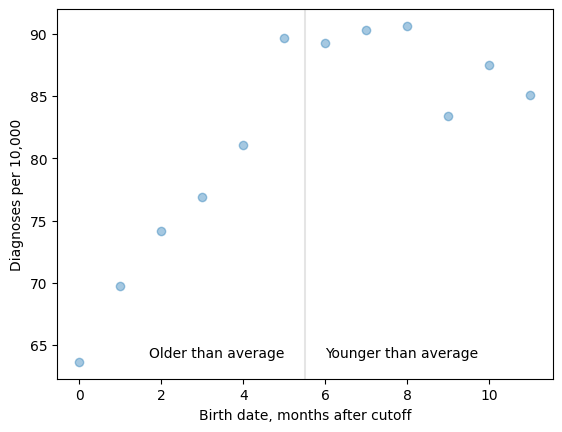

In [61]:
# Plot the diagnosis rates

plt.plot(adhd['x'], adhd['rate'], 'o', label='data', color='C0', alpha=0.4)
plt.axvline(5.5, color='gray', alpha=0.2)
plt.text(6, 64, 'Younger than average')
plt.text(5, 64, 'Older than average', horizontalalignment='right')
plt.xlabel('Birth date, months after cutoff')
plt.ylabel('Diagnoses per 10,000')

In [62]:
# For the 1st 9 months, we see increasing diagnosis rates for each month of difference in age
# We can start by modeling these months, then figure out how to handle the last 3 months
# Start with priors

qs = np.linspace(-5.2, -4.6, num=51)
prior_inter = make_uniform(qs, name='Intercept')

qs = np.linspace(0.0, 0.08, num=51)
prior_slope = make_uniform(qs, name='Slope')

# Then we make a joint distribution, and update using data from the 1st 9 months

joint = make_joint(prior_inter, prior_slope)
joint_pmf = Pmf(joint.stack())

num_legit = 9
adhd1 = adhd.loc[0:num_legit-1]
adhd2 = adhd.loc[num_legit:]

from scipy.stats import binom

likelihood1 = joint_pmf.copy()

xs = adhd1['x']
ks = adhd1['k']
ns = adhd1['n']

for slope, inter in joint_pmf.index:
    ps = expit(inter + slope * xs)
    likes = binom.pmf(ks, ns, ps)
    likelihood1[slope, inter] = likes.prod()
    
likelihood2 = joint_pmf.copy()

xs = adhd2['x']
ks = adhd2['k']
ns = adhd2['n']

for slope, inter in joint_pmf.index:
    ps = expit(inter + slope * xs)
    likes = binom.sf(ks, ns, ps) # This uses the survival function to compute prob that n cases > ks
    likelihood2[slope, inter] = likes.prod()
    
posterior_pmf = joint_pmf * likelihood1
posterior_pmf.normalize()

posterior_pmf.max_prob()

(np.float64(0.0448), np.float64(-4.996))

In [63]:
posterior_pmf = joint_pmf * likelihood1 * likelihood2
posterior_pmf.normalize()
posterior_pmf.max_prob()

(np.float64(0.0448), np.float64(-4.996))

In [64]:
joint_posterior = posterior_pmf.unstack()

marginal_inter = marginal(joint_posterior, 0)
marginal_slope = marginal(joint_posterior, 1)

print(marginal_inter.mean(), marginal_slope.mean())

-4.999322906782618 0.04460761677198374


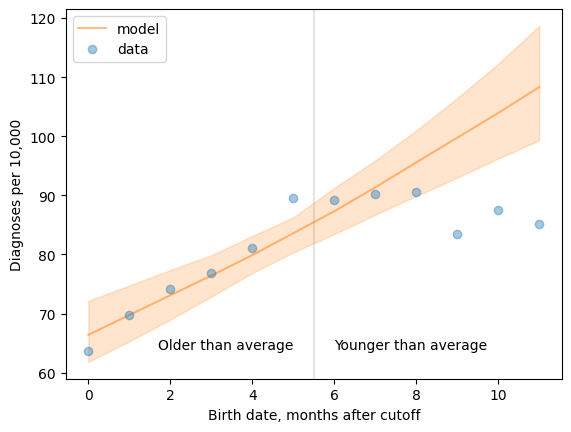

In [65]:
# Then sample the posterior and compute median probability of diagnosis by month

sample = posterior_pmf.choice(101)
xs = adhd['x']
ps = np.empty((len(sample), len(xs)))

for i, (slope, inter) in enumerate(sample):
    ps[i] = expit(inter + slope * xs)
    
low, median, high = np.percentile(ps, [2.5, 50, 97.5], axis=0)

plt.fill_between(xs, low*10000, high*10000, color='C1', alpha=0.2)
plt.plot(xs, median*10000, label='model', color='C1', alpha=0.5)
plt.plot(adhd['x'], adhd['rate'], 'o', label='data', color='C0', alpha=0.4)
plt.axvline(5.5, color='gray', alpha=0.2)
plt.text(6, 64, 'Younger than average')
plt.text(5, 64, 'Older than average', horizontalalignment='right')
plt.xlabel('Birth date, months after cutoff')
plt.ylabel('Diagnoses per 10,000')
plt.legend()